In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse-cic-ids2018-combined-extracted-features/X_test_combined.npy
/kaggle/input/cse-cic-ids2018-combined-extracted-features/X_train_combined.npy
/kaggle/input/scaling-and-smote/train_smote.pkl
/kaggle/input/scaling-and-smote/train_test_split.pkl
/kaggle/input/cse-cic-ids2018-final-model/tensorflow2/default/1/Final_model.pkl


In [2]:
combined_features_train = np.load('/kaggle/input/cse-cic-ids2018-combined-extracted-features/X_train_combined.npy')
combined_features_test = np.load('/kaggle/input/cse-cic-ids2018-combined-extracted-features/X_test_combined.npy')

In [3]:
import joblib

X_train_smote, y_train_smote = joblib.load('/kaggle/input/scaling-and-smote/train_smote.pkl')
y_test = joblib.load('/kaggle/input/scaling-and-smote/train_test_split.pkl')[3]

In [20]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=3, n_jobs=-1)),
    ('lr', LogisticRegression(max_iter=1000))
]
meta_model=XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=3, n_jobs=-1)

model=StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=2, n_jobs=-1)

model.fit(combined_features_train, y_train_smote)

In [21]:
import joblib
from IPython.display import FileLink

joblib.dump(model, 'Final_model.pkl')
FileLink(r'Final_model.pkl')

/kaggle/working/Final_model.pkl

In [7]:
model = joblib.load('/kaggle/input/cse-cic-ids2018-final-model/tensorflow2/default/1/Final_model.pkl')

y_pred_test = model.predict(combined_features_test)
#y_pred_train = model.predict(combined_features_train)

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = conf_matrix.ravel()
fpr = fp / (fp + tn)
roc_auc = roc_auc_score(y_test, y_pred_test)

report = classification_report(y_test, y_pred_test, target_names=['Benign', 'Malicious'])

print('Accuracy:', accuracy)
print('\nPrecision:', precision)
print('\nRecall:', recall)
print('\nF1 Score:', f1)
print('\nConfusion Matrix: \n', conf_matrix)
print('\nFalse Positive Rate:', fpr)
print('\nROC-AUC:', roc_auc)
print('\nClassification Report: \n', report)

Accuracy: 0.9847144619906554

Precision: 0.9470808887178994

Recall: 0.927228897510264

F1 Score: 0.9370497606653788

Confusion Matrix: 
 [[376913   2751]
 [  3864  49234]]

False Positive Rate: 0.007245880568081251

ROC-AUC: 0.9599915084710914

Classification Report: 
               precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    379664
   Malicious       0.95      0.93      0.94     53098

    accuracy                           0.98    432762
   macro avg       0.97      0.96      0.96    432762
weighted avg       0.98      0.98      0.98    432762



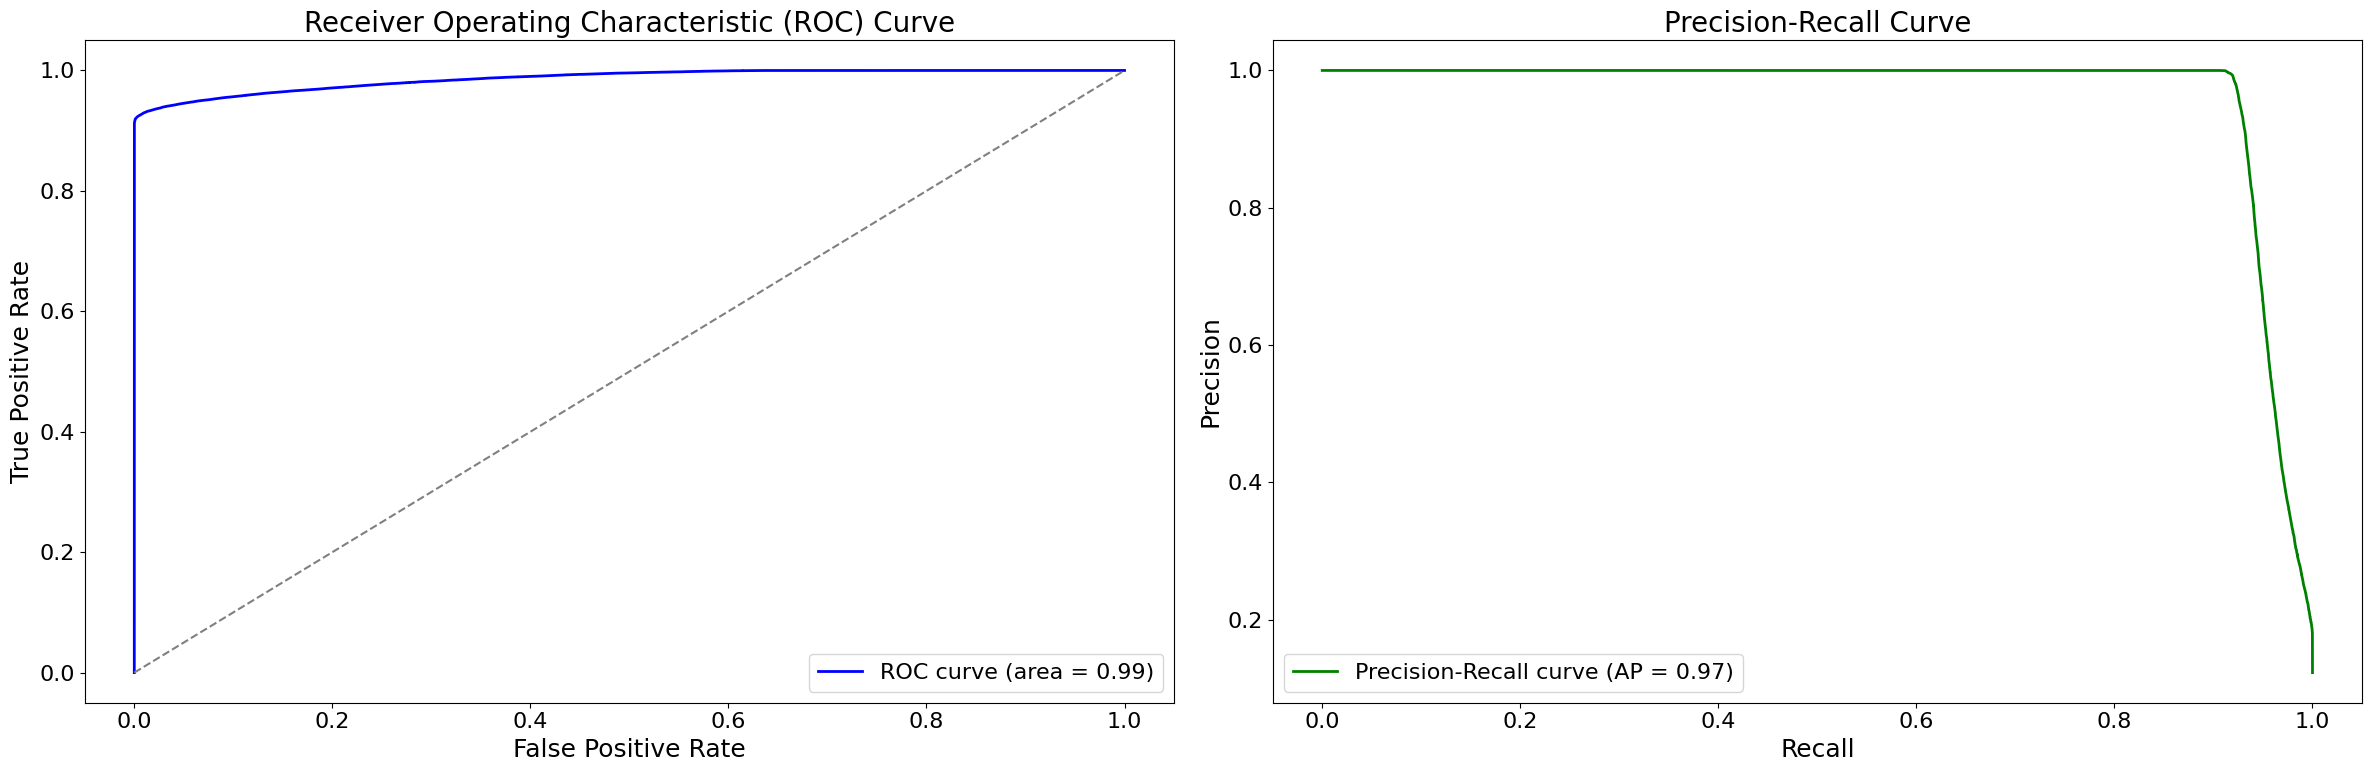

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

# ROC Curve
y_prob = model.predict_proba(combined_features_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Set global font size
plt.rcParams.update({'font.size': 16})

# Set up the figure for subplots
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# ROC Curve
axs[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_xlabel('False Positive Rate', fontsize=18)
axs[0].set_ylabel('True Positive Rate', fontsize=18)
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
axs[0].legend(loc='lower right', fontsize=16)

# Precision-Recall Curve
axs[1].plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
axs[1].set_xlabel('Recall', fontsize=18)
axs[1].set_ylabel('Precision', fontsize=18)
axs[1].set_title('Precision-Recall Curve', fontsize=20)
axs[1].legend(loc='lower left', fontsize=16)

plt.tight_layout()
plt.show()